# Running NeuralGCM

_By: Luke Madaus -- 24 Oct 2024 -- madaus@wisc.edu / luke.madaus@rwe.com_

NeuralGCM is a state-of-the-art atmosphere-only "climate" model developed by a team at Google Research and DeepMind, with consulting from ECMWF, MIT and Harvard.  It is unique in that they built a dynamic core using the JAX library (called `dinosaur`), which has automatic differentiation built in to all operations implemented through JAX.  This lets the model estimate how small changes in physical parameterizations will also affect the dynamics, so the model can be trained to optimize both physics and dynamics at the same time.
You can read more about the model in their publication on ArXiv:

https://arxiv.org/abs/2311.07222

This notebook is almost an exact duplicate of their example forecast notebook shown at this website, so feel free to go there for additional details and options.  I edited it to focus on a quicker demo:
https://neuralgcm.readthedocs.io/en/latest/inference_demo.html

## Overview
This notebook uses ERA5 data and pretrained NeuralGCM model to make a weather forecast.

The forecast is made in 3 steps:

1. Slice of ERA5 data is regridded to model resolution

2. NeuralGCM model state is initialized and rolled out

3. Predictions and reference trajectory are combined for visualization

_**This**_ notebook uses intermediate deterministic NeuralGCM 2.8° model. Other available checkpoints include deterministic 0.7°, 1.4° and stochastic 1.4° NeuralGCM variations.



## Install the package
This installs the package and all needed dependencies.  We also install the `gcsfs` library to let us read ERA5 reanalysis data directly from the Google public cloud storage. A recent update to the JAX library since the NeuralGCM code was released causes the model to break, so we pin to the most recent working version.

We also install matplotlib and cartopy to make plots of the output.

In [14]:
!pip install neuralgcm gcsfs "jax==0.4.33" cartopy matplotlib

/Users/lmadaus/miniforge3/envs/amb/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  Using cached shapely-2.0.6-cp311-cp311-macosx_11_0_arm64.whl.metadata (7.0 kB)
  Using cached pyshp-2.3.1-py2.py3-none-any.whl.metadata (55 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 21.5 MB/s eta 0:00:00MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 28.4 MB/s eta 0:00:00 MB/s eta 0:00:01
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 27.8 MB/s eta 0:00:00
Using cached pyshp-2.3.1-py2.py3-none-any.whl (46 kB)
Using cached shapely-2.0.6-cp311-cp311-macosx_11_0_arm64.whl (1.3 MB)


## Import needed libraries

In [2]:
import gcsfs
import jax
import numpy as np
import pickle
import xarray

from dinosaur import horizontal_interpolation
from dinosaur import spherical_harmonic
from dinosaur import xarray_utils
import neuralgcm

gcs = gcsfs.GCSFileSystem(token='anon')

## Load a pre-trained NeuralGCM model

Note: Trained model weights are licensed for non-commercial use, under the Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International license (CC BY-NC-SA 4.0).

Pre-trained model checkpoints from the NeuralGCM paper are available for download on Google Cloud Storage:

Deterministic models:

- `gs://gresearch/neuralgcm/04_30_2024/neural_gcm_dynamic_forcing_deterministic_0_7_deg.pkl`
- `gs://gresearch/neuralgcm/04_30_2024/neural_gcm_dynamic_forcing_deterministic_1_4_deg.pkl`
- `gs://gresearch/neuralgcm/04_30_2024/neural_gcm_dynamic_forcing_deterministic_2_8_deg.pkl`

Stochastic models:

- `gs://gresearch/neuralgcm/04_30_2024/neural_gcm_dynamic_forcing_stochastic_1_4_deg.pkl`

In [3]:
model_name = 'neural_gcm_dynamic_forcing_deterministic_2_8_deg.pkl'

with gcs.open(f'gs://gresearch/neuralgcm/04_30_2024/{model_name}', 'rb') as f:
  ckpt = pickle.load(f)

model = neuralgcm.PressureLevelModel.from_checkpoint(ckpt)

### What do these weights actually look like?


In [4]:
ckpt

{'params': {'stochastic_modular_step_model/~/dimensional_learned_primitive_to_weatherbench_decoder/nodal_mapping/~/epd_tower/decode_tower/~/mlp_uniform/~/linear_0': {'w': Array([[-2.5926113e-01, -3.9585203e-01, -1.7715451e-01, ...,
           -6.3094464e-03, -6.2745609e-03, -7.1149534e-03],
          [-7.0433778e-01, -5.4148585e-01, -5.1081055e-01, ...,
           -1.3190911e-03, -2.9965711e-03, -3.5329687e-03],
          [ 6.0038620e-01,  7.9733884e-01,  6.7303342e-01, ...,
           -2.6150869e-04,  9.6321153e-04,  2.9420303e-03],
          ...,
          [-9.2187607e-01, -5.4585642e-01, -3.7611374e-01, ...,
           -8.8521726e-03, -9.8780449e-03, -1.1607496e-02],
          [-6.2222020e-03,  1.2762882e+00,  1.2854989e+00, ...,
            1.2860072e-03,  1.9058202e-04,  7.2369108e-04],
          [ 8.9719379e-01,  6.4458859e-01,  4.8302868e-01, ...,
           -1.0257665e-03, -1.9785730e-04,  4.8838533e-04]], dtype=float32)},
  'stochastic_modular_step_model/~/dimensional_learned_

## Load ERA5 data from the public cloud

This is a great resource for anyone who wants to look at ERA5 data without needed to download it from Copernicus, etc.  A good chunk is available for free directly from the cloud!

In [5]:
era5_path = 'gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3'
full_era5 = xarray.open_zarr(gcs.get_mapper(era5_path), chunks=None)

demo_start_time = '2020-02-14'
demo_end_time = '2020-02-18'
data_inner_steps = 24  # process every 24th hour

sliced_era5 = (
    full_era5
    [model.input_variables + model.forcing_variables]
    .pipe(
        xarray_utils.selective_temporal_shift,
        variables=model.forcing_variables,
        time_shift='24 hours',
    )
    .sel(time=slice(demo_start_time, demo_end_time, data_inner_steps))
    .compute()
)

In [6]:
# Pre-load saved version of this data, since four days of data with 37 pressure levels can take a while to download
#sliced_era5 = xr.open_zarr('saved_era5.zarr')

## Regrid to NeuralGCM resolution you requested

This uses conservative regridding to regrid the input ERA5 data on the 0.25 degree grid to whatever grid resolution of model you requested.  It also fills any NaN values with nearest-neighbors.  This is because during the regridding, certain variables like sea-surface temperatures (only defined over ocean) may be mismatched with the land mask in the regridded data.

Note this is a very fast conservative regridder...faster than things like `xesmf`...

In [7]:
era5_grid = spherical_harmonic.Grid(
    latitude_nodes=full_era5.sizes['latitude'],
    longitude_nodes=full_era5.sizes['longitude'],
    latitude_spacing=xarray_utils.infer_latitude_spacing(full_era5.latitude),
    longitude_offset=xarray_utils.infer_longitude_offset(full_era5.longitude),
)
regridder = horizontal_interpolation.ConservativeRegridder(
    era5_grid, model.data_coords.horizontal, skipna=True
)
eval_era5 = xarray_utils.regrid(sliced_era5, regridder)
eval_era5 = xarray_utils.fill_nan_with_nearest(eval_era5)

## Make the forecast
This is set up to make a four-day forecast, and save the model output only once every 24 time steps (model steps hourly, so this is one output per day).

In [11]:
%%time
inner_steps = 24  # save model outputs once every 24 hours
outer_steps = 4 * 24 // inner_steps  # total of 4 days
timedelta = np.timedelta64(1, 'h') * inner_steps
times = (np.arange(outer_steps) * inner_steps)  # time axis in hours

# initialize model state
# The model has a method to identify which variables in the xarray
# dataset are needed as inputs to the model, and only extract those
inputs = model.inputs_from_xarray(eval_era5.isel(time=0))

# It also has a function to identify the forcing variables
input_forcings = model.forcings_from_xarray(eval_era5.isel(time=0))

# You can see which variables are forcing variables here:
# - sea_ice_cover
# - sea_surface_temperature
# - the time of the initial condition state
input_forcings

CPU times: user 10.3 ms, sys: 17.7 ms, total: 27.9 ms
Wall time: 27.6 ms


{'sea_ice_cover': array([[[0.02208347, 0.02208347, 0.02208347, ..., 0.9622189 ,
          0.99999875, 0.99999964],
         [0.02208347, 0.02208347, 0.02208347, ..., 0.955263  ,
          1.        , 1.        ],
         [0.02208347, 0.02208347, 0.02208347, ..., 0.94853866,
          1.        , 1.        ],
         ...,
         [0.02208347, 0.02208347, 0.02208347, ..., 0.93866414,
          0.9875427 , 0.9984242 ],
         [0.02208347, 0.02208347, 0.02208347, ..., 0.96181065,
          0.9973755 , 0.9994512 ],
         [0.02208347, 0.02208347, 0.02208347, ..., 0.964194  ,
          0.9998887 , 0.9999966 ]]], dtype=float32),
 'sea_surface_temperature': array([[[271.94254, 271.94254, 271.94254, ..., 271.4599 , 271.4599 ,
          271.4598 ],
         [271.94254, 271.94254, 271.94254, ..., 271.4599 , 271.4599 ,
          271.45984],
         [271.94254, 271.94254, 271.94254, ..., 271.45987, 271.45987,
          271.45978],
         ...,
         [271.94254, 271.94254, 271.94254, ...

In [12]:
%%time
# To start the prediction, we first "encode" the initial conditions and forcings into
# the model's transformed space
rng_key = jax.random.key(42)  # optional for deterministic models
initial_state = model.encode(inputs, input_forcings, rng_key)

# use persistence for forcing variables (SST and sea ice cover)
# You could instead have an array that varies over time
all_forcings = model.forcings_from_xarray(eval_era5.head(time=1))

# make forecast
# This is called "unrolling" the predictions
# or doing "rollout" in AI jargon
final_state, predictions = model.unroll(
    initial_state,
    all_forcings,
    steps=outer_steps,
    timedelta=timedelta,
    start_with_input=True,
)
# This decodes the predictions back into normal lat-lon space
predictions_ds = model.data_to_xarray(predictions, times=times)
predictions_ds

CPU times: user 40 ms, sys: 21.5 ms, total: 61.6 ms
Wall time: 22.3 ms


<xarray.Dataset> Size: 34MB
Dimensions:                              (time: 4, level: 37, longitude: 128,
                                          latitude: 64)
Coordinates:
  * longitude                            (longitude) float64 1kB 0.0 ... 357.2
  * latitude                             (latitude) float64 512B -87.86 ... 8...
  * level                                (level) int64 296B 1 2 3 ... 975 1000
  * time                                 (time) int64 32B 0 24 48 72
Data variables:
    sim_time                             (time) float32 16B ...
    specific_cloud_ice_water_content     (time, level, longitude, latitude) float32 5MB ...
    temperature                          (time, level, longitude, latitude) float32 5MB ...
    u_component_of_wind                  (time, level, longitude, latitude) float32 5MB ...
    geopotential                         (time, level, longitude, latitude) float32 5MB ...
    specific_humidity                    (time, level, longitude, latitude) float32 5MB ...
    specific_cloud_liquid_water_content  (time, level, longitude, latitude) float32 5MB ...
    v_component_of_wind                  (time, level, longitude, latitude) float32 5MB ...
Attributes:
    longitude_wavenumbers:     64
    total_wavenumbers:         65
    longitude_nodes:           128
    latitude_nodes:            64
    latitude_spacing:          gauss
    longitude_offset:          0.0
    radius:                    1.0
    spherical_harmonics_impl:  RealSphericalHarmonics
    spmd_mesh:                 
    centers:                   [1, 2, 3, 5, 7, 10, 20, 30, 50, 70, 100, 125, ...
    horizontal_grid_type:      Grid
    vertical_grid_type:        PressureCoordinates

## Look at the output

Since this is an xarray dataset, we can pretty easily look at the output directly.

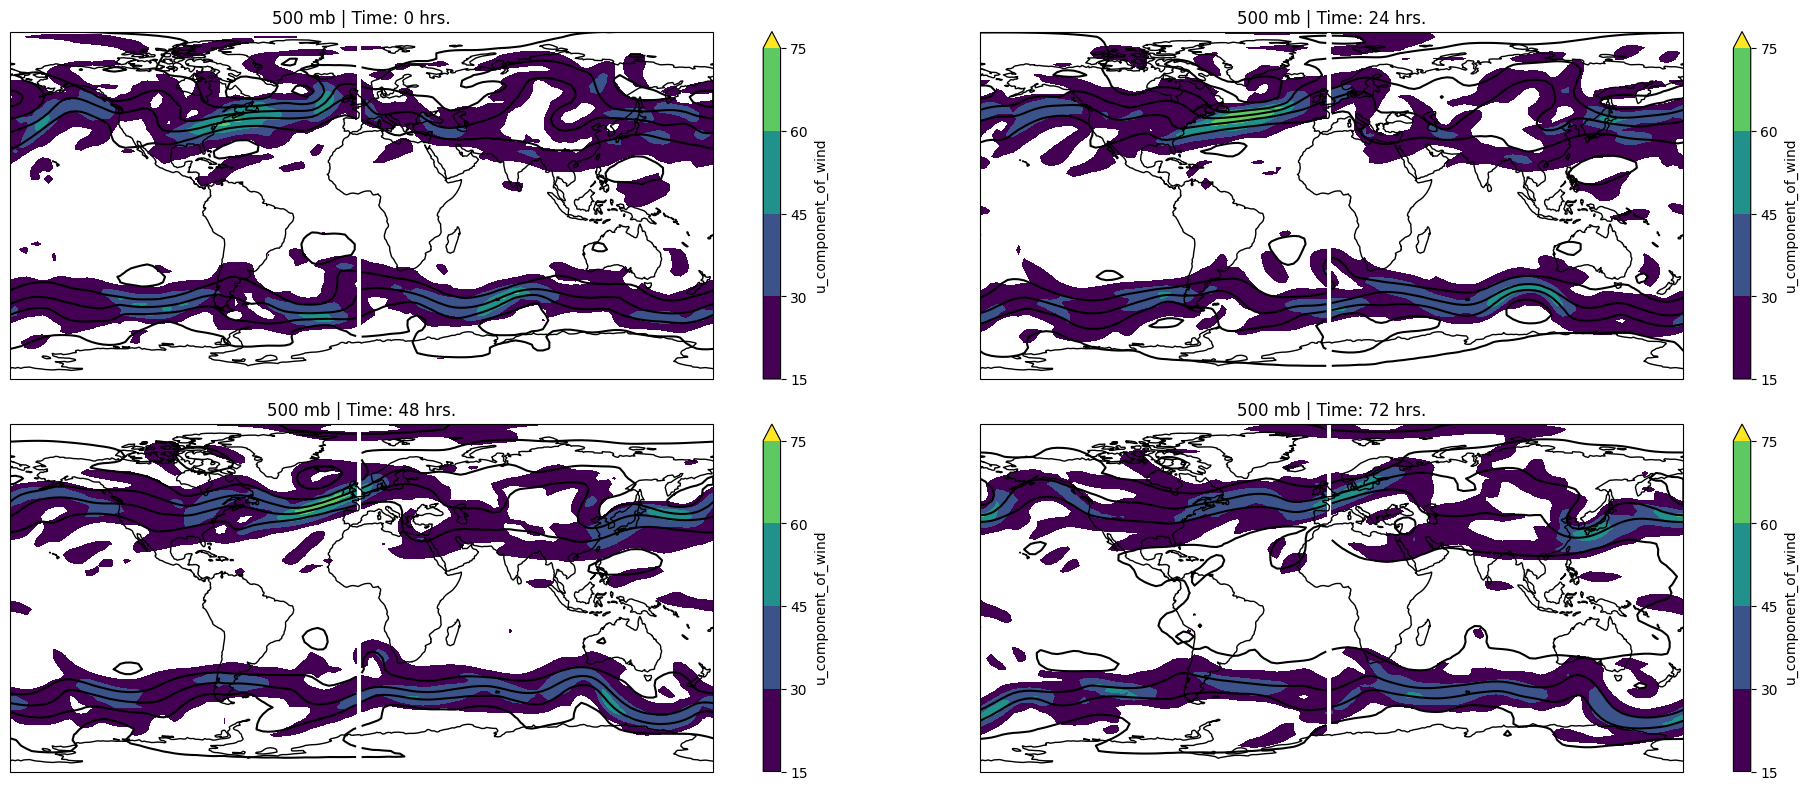

In [24]:
import matplotlib.pyplot as plt
import cartopy
proj = cartopy.crs.PlateCarree()

# Make plots at 500mb level
plev = 500

plt.figure(figsize=(20,8))
for tnum, time in enumerate(predictions_ds.time.values):
    ax = plt.subplot(2,2,tnum+1, projection=proj)
    # Color in the wind speeds on a pressure level
    wspd = np.hypot(predictions_ds['u_component_of_wind'].sel(level=plev, time=time), predictions_ds['v_component_of_wind'].sel(level=plev, time=time))
    wspd.T.plot.contourf(ax=ax, levels=[15,30,45,60,75], extend='max')

    # Also contour geopotential height
    gph = predictions_ds['geopotential'].sel(level=plev, time=time)
    gph.T.plot.contour(ax=ax, colors='k')

    ax.set_title(f'{plev} mb | Time: {time} hrs.')
    ax.coastlines()
plt.tight_layout()
plt.show()